In [1]:
%matplotlib inline
from __future__ import division
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import struct
import pickle
import pandas as pd
import random

In [3]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.datasets import imdb
from keras.utils import to_categorical
from keras.layers import Conv1D, MaxPooling1D

Using TensorFlow backend.


In [4]:
import sys
sys.path.append('../../src')

In [5]:
from pylab import rcParams
from IPython.display import clear_output
rcParams['figure.figsize'] = 16, 8
pd.options.display.max_columns = 999

In [6]:
from utils import FloatConvert32, FloatConvert64
from microssembly2 import Microssembly
from price_generator import random_walk, random_price
from simple_strategy import plot_trades

In [7]:
all_stocks = pd.read_csv('../../R_stock signal/allstocks1.csv', index_col='Date')
all_stocks.index = pd.to_datetime(all_stocks.index)
symbols = np.unique(all_stocks.Company)
symbols.shape

(30,)

In [9]:
def get_price(symbol=None, days = 127):
    symbol = symbol if symbol else np.random.choice(symbols)
    data = all_stocks[all_stocks.Company == np.random.choice(symbols)]
    min_day, max_day = min(data.index), max(data.index)
    start_day = np.random.choice(pd.date_range(start=min_day, end=max_day, freq='D'))
    end_day = start_day + np.timedelta64(days, 'D')
    return data[start_day: end_day]

In [10]:
def get_strategy_signal(price):
    signal = pd.Series(index=price.index)
    signal[price.buy == 1] = 1
    signal[price.sell == 1] = 0
    signal

    return signal

In [11]:
def plot_signals(observed_signal, signal):
    df = pd.DataFrame({'true': observed_signal - 0.5, 'generated': signal - 0.5}, index=observed_signal.index)
    ax = df.plot.bar()
    my_xticks = ['Sell', 'Buy']
    ax.set_yticks([-1, 1])
    ax.set_yticklabels(my_xticks)
    ax.set_xticklabels([])

In [12]:
def pad_left(series, n):
        head = series.index[0]
        pad_value = series[0]
        pad = pd.Series(np.full(n, pad_value), index=pd.date_range(start = head - pd.DateOffset(days=n-1),
                                                                   end = head) - pd.DateOffset(days=1))
        return pad.append(series)

In [13]:
def price_2_seq(price, window = 8):
    p = (price - price.shift(1)).fillna(0)
    p = pad_left(p, window - 1)
    return np.array([p.shift(-x).values[:window] for x in range(len(p) - (window - 1))[::]])

In [14]:
def features(price, window):
    f1 = np.expand_dims(price_2_seq(price.Open, window), axis=2)
    f2 = np.expand_dims(price_2_seq(price.Close, window), axis=2)
    f3 = np.expand_dims(price_2_seq(price.High, window), axis=2)
    f4 = np.expand_dims(price_2_seq(price.Low, window), axis=2)
    return np.concatenate([f1, f2, f3, f4], axis=2)

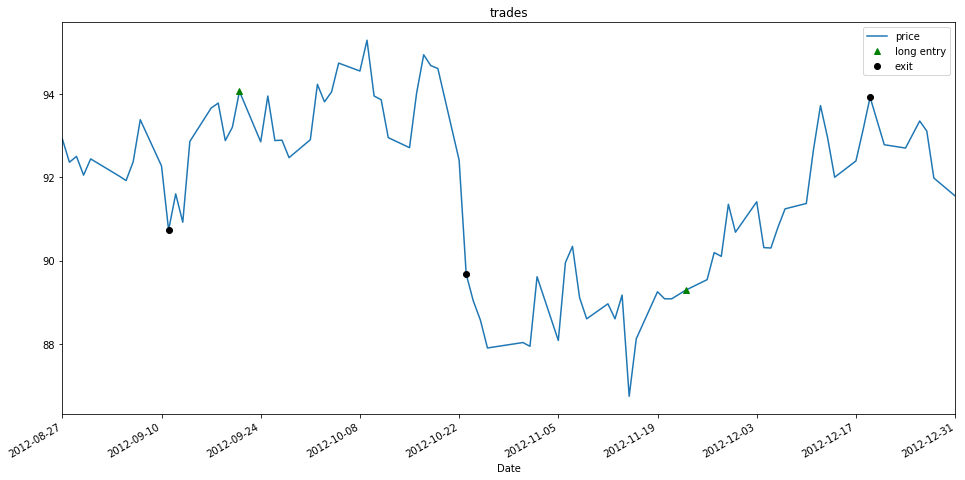

In [15]:
price = get_price()
signal = get_strategy_signal(price)
plot_trades(price.Open, signal, plt)

In [16]:
days = 2 * 365
seq_length = 60

In [17]:
price = get_price(symbol=symbols[0], days=days)
signal = get_strategy_signal(price)
for symbol in symbols[1:]:
    p = get_price(symbol=symbol, days=days)
    s = get_strategy_signal(p)
    price = price.append(p)
    signal = signal.append(s)
    
price.shape, signal.shape

((14317, 11), (14317,))

In [18]:
Y = to_categorical(signal.fillna(2).values)
X = features(price, window=seq_length)
test_cutoff = int(len(X) * 0.8)
x_train = X[:test_cutoff]
y_train = Y[:test_cutoff]
x_test = X[test_cutoff:]
y_test = Y[test_cutoff:]
buy_weight = int(len(signal[signal.isna()]) / len(signal[signal == 1]))
sell_weight = int(len(signal[signal.isna()]) / len(signal[signal == 0]))
x_train.shape, y_train.shape, x_test.shape, y_test.shape, buy_weight, sell_weight

((11453, 60, 4), (11453, 3), (2864, 60, 4), (2864, 3), 48, 48)

In [19]:
model = Sequential()
model.add(LSTM(16, input_shape=(seq_length, 4), return_sequences=True))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [20]:
model.fit(x_train, y_train,
              batch_size=32,
              epochs=50,
              validation_data=(x_test, y_test), class_weight={0:sell_weight, 1:buy_weight, 2:1})

Train on 11453 samples, validate on 2864 samples
Epoch 1/50
11453/11453 [==============================] - 45s 4ms/step - loss: 2.9728 - val_loss: 1.0643
Epoch 2/50
11453/11453 [==============================] - 43s 4ms/step - loss: 2.6739 - val_loss: 1.0864
Epoch 3/50
11453/11453 [==============================] - 42s 4ms/step - loss: 2.3856 - val_loss: 1.0777
Epoch 4/50
11453/11453 [==============================] - 42s 4ms/step - loss: 2.1382 - val_loss: 0.8996
Epoch 5/50
11453/11453 [==============================] - 42s 4ms/step - loss: 1.8784 - val_loss: 0.9356
Epoch 6/50
11453/11453 [==============================] - 42s 4ms/step - loss: 1.7944 - val_loss: 0.7317
Epoch 7/50
11453/11453 [==============================] - 42s 4ms/step - loss: 1.7219 - val_loss: 0.7268
Epoch 8/50
11453/11453 [==============================] - 42s 4ms/step - loss: 1.6613 - val_loss: 0.9002
Epoch 9/50
11453/11453 [==============================] - 42s 4ms/step - loss: 1.5855 - val_loss: 0.8131
Epoch 

In [21]:
price = get_price()
signal = get_strategy_signal(price)
f = features(price, window=seq_length)
predicted_signal = pd.Series(np.argmax(model.predict(f), axis=1), index=price.index).replace(2, np.nan)

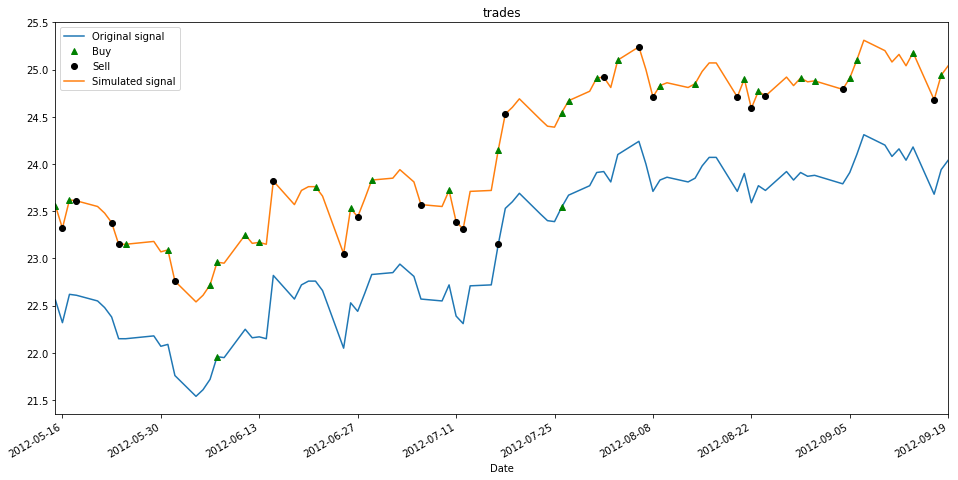

In [22]:
plot_trades(price.Open, signal, plt)
plot_trades(price.Open + 1, predicted_signal, plt)
plt.legend(['Original signal', 'Buy', 'Sell', 'Simulated signal'], loc='best')